### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [13]:
from src.load_datasets import load_climate_change_data


dataframe = (
    load_climate_change_data()
    .pipe(format_datetime, col="Date Time")
    .pipe(set_index, col="Date Time")
    .pipe(resample_data, freq="H")
    .pipe(interpolate_column)
)

print(f"dataframe shape {dataframe.shape}")

dataframe = dataframe[
    ["p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)"]
].copy(deep=True)

dataframe.head()

format_datetime: DF Shape (420551, 15)
set_index: DF Shape (420551, 14)
resample_Data: DF Shape (70129, 14)
interpolate_columns: DF Shape (70129, 14)
dataframe shape (70129, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%)
Date Time,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333


In [14]:
dataframe.isna().sum()

p (mbar)       0
T (degC)       0
Tpot (K)       0
Tdew (degC)    0
rh (%)         0
dtype: int64

In [15]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%)
p (mbar),1.000000,-0.044493,-0.124053,-0.065985,-0.019277
T (degC),-0.044493,1.000000,0.996810,0.896871,-0.572036
Tpot (K),-0.124053,0.996810,1.000000,0.896059,-0.566696
Tdew (degC),-0.065985,0.896871,0.896059,1.000000,-0.158644
rh (%),-0.019277,-0.572036,-0.566696,-0.158644,1.000000


### Test Train split

train_xy and test_xy size: (70114, 5), (15, 5)

y_train and x_train size (70114,), (70114, 4)
y_test  and x_test  size (15,),  (15, 4)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Tdew (degC)'>)

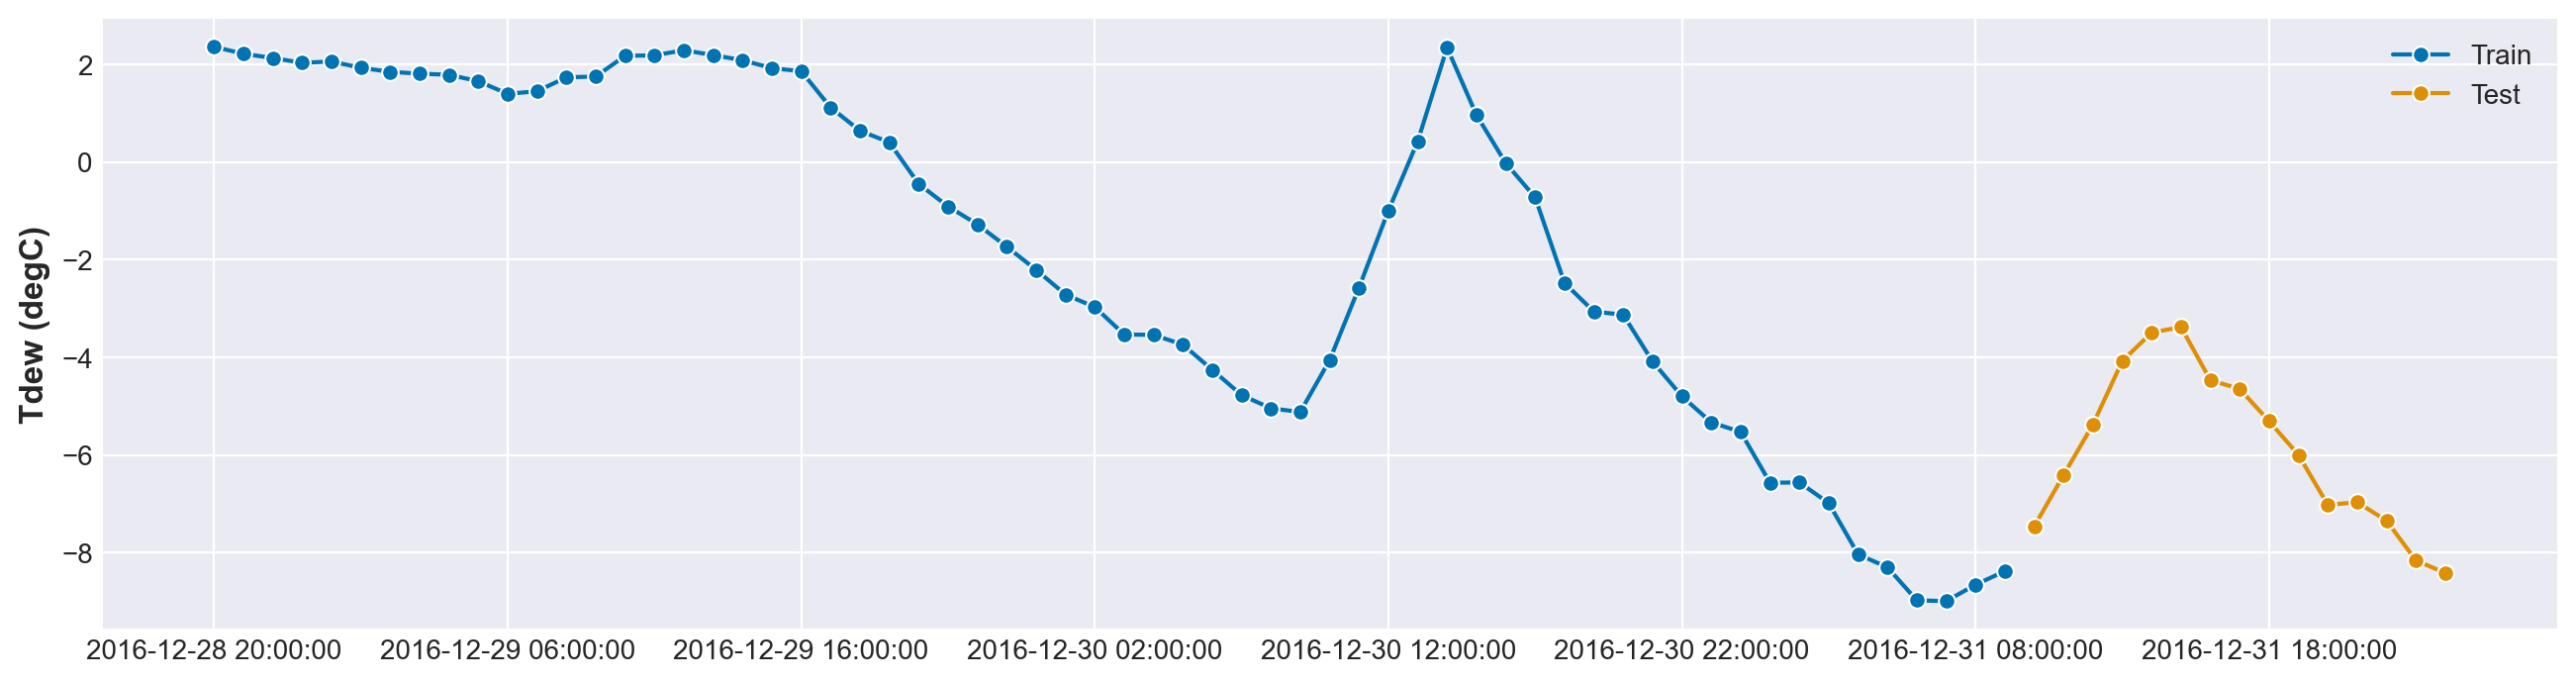

In [17]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "Tdew (degC)"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(62), y_test, labels=["Train", "Test"])

#### Huyper Parameter Selection 

intital_window_size 70039 , step_length 15 for fold 5


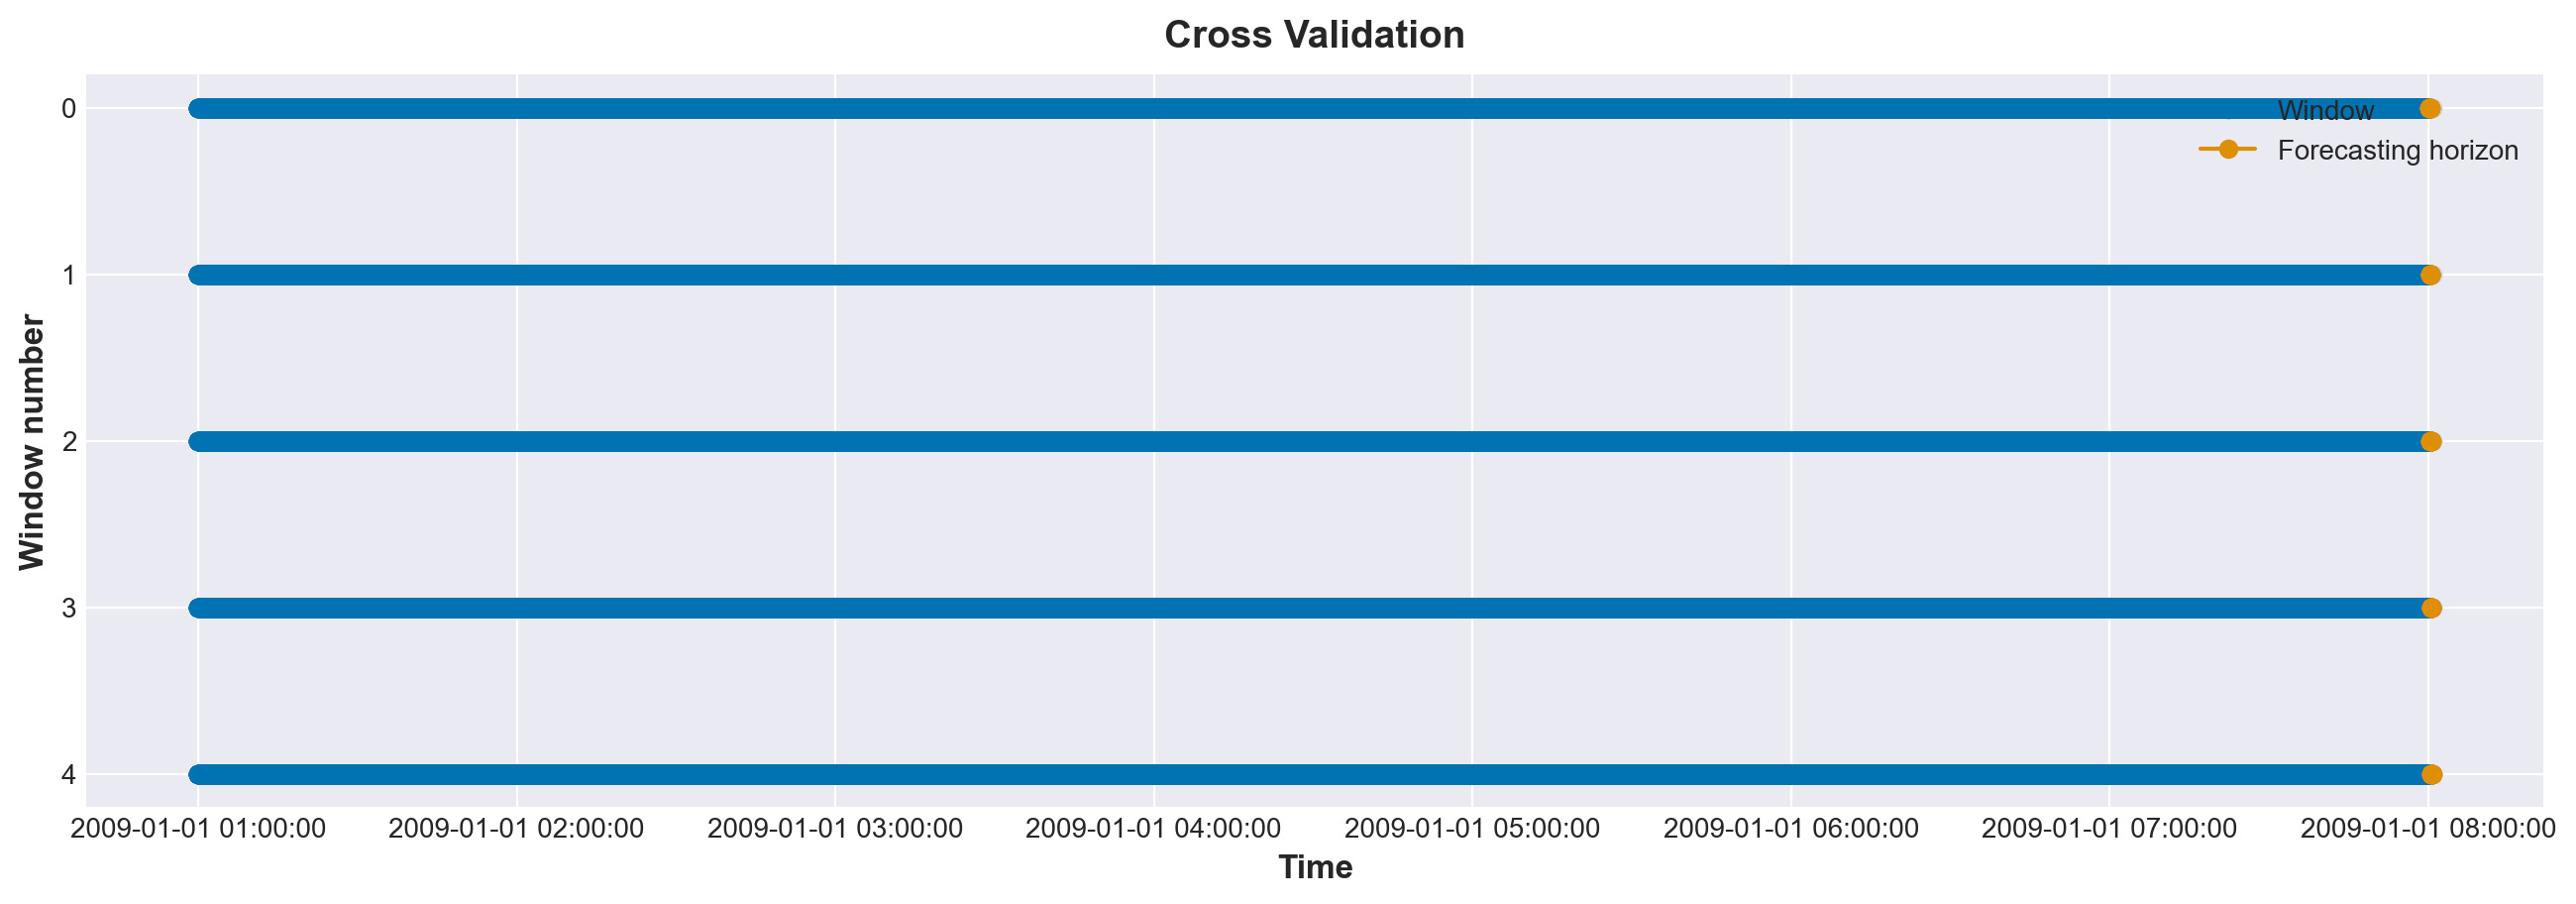

In [18]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

y_size = len(y_train)

fold = 5

step_length = len(fh)

fh_max_length = max(fh)

intital_window_size = y_size - ((fold - 1) * step_length + 1 * fh_max_length)

# intital_window_size = int(y_train.shape[0] * 0.80)

print(
    f"intital_window_size {intital_window_size} , step_length {step_length} for fold {fold}"
)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

plot_windows(cv, y_train, title="Cross Validation")

In [48]:
%%time

from sklearn.preprocessing import MinMaxScaler

try:
    from sklearnex.linear_model import Ridge

    print("Importing sklearnex Ridge")
except ImportError:
    from sklearn.linear_model import Ridge

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import (
    Detrender,
    Deseasonalizer,
    ConditionalDeseasonalizer,
)
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsoluteError

param_grid = {
    # "forecaster__deseasonalizer__model": ["additive", "multiplicative"],
    "scaler_x__passthrough": [True, False],
    "forecaster__deseasonalizer__model": ["additive"],
    "forecaster__deseasonalizer__sp": [24],
    "forecaster__detrender__forecaster__degree": [1, 2],
    "forecaster__reducer__window_length": [24],
    "forecaster__reducer__estimator__fit_intercept": [True, False],
    "forecaster__reducer__estimator__alpha": [0.01, 0.1, 1, 10],
}

forecaster_pipe = ForecastingPipeline(
    steps=[
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        (
            "scaler_x",
            OptionalPassthrough(
                TabularToSeriesAdaptor(MinMaxScaler()), passthrough=False
            ),
        ),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    (
                        "deseasonalizer",
                        ConditionalDeseasonalizer(model="additive", sp=24),
                    ),
                    (
                        "detrender",
                        Detrender(forecaster=PolynomialTrendForecaster(degree=1)),
                    ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=Ridge(random_state=80),
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="global",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

print(f"Number of CPU Count:   {os.cpu_count()}")

n_cpu = os.cpu_count() - 1 if os.cpu_count() > 2 else 1

gscv = ForecastingGridSearchCV(
    forecaster_pipe,
    strategy="refit",
    scoring=MeanAbsoluteError(),
    cv=cv,
    param_grid=param_grid,
    verbose=10,
    n_jobs=n_cpu,
    refit=True,
    error_score="raise",
)

gscv.fit(y_train, X=x_train, fh=fh)

print("Best Params", gscv.best_params_)
print("Best scores", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)

Importing sklearnex ElasticNet
Number of CPU Count:   12
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Params {'forecaster__deseasonalizer__model': 'additive', 'forecaster__deseasonalizer__sp': 24, 'forecaster__detrender__forecaster__degree': 2, 'forecaster__reducer__estimator__alpha': 0.1, 'forecaster__reducer__estimator__fit_intercept': False, 'forecaster__reducer__window_length': 24, 'scaler_x__passthrough': False}
Best scores 0.735387970803966
CPU times: total: 7.52 s
Wall time: 2min 57s


In [49]:
print(x_test.columns)

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'rh (%)'], dtype='object')


2016-12-31 10:00:00   -7.676906
2016-12-31 11:00:00   -6.907813
2016-12-31 12:00:00   -6.161728
2016-12-31 13:00:00   -5.170122
2016-12-31 14:00:00   -4.279651
2016-12-31 15:00:00   -3.678461
2016-12-31 16:00:00   -3.750376
2016-12-31 17:00:00   -3.914162
2016-12-31 18:00:00   -4.229001
2016-12-31 19:00:00   -4.734302
2016-12-31 20:00:00   -5.479309
2016-12-31 21:00:00   -5.972078
2016-12-31 22:00:00   -6.407185
2016-12-31 23:00:00   -7.085200
2017-01-01 00:00:00   -7.614684
Freq: H, Name: Tdew (degC), dtype: float64

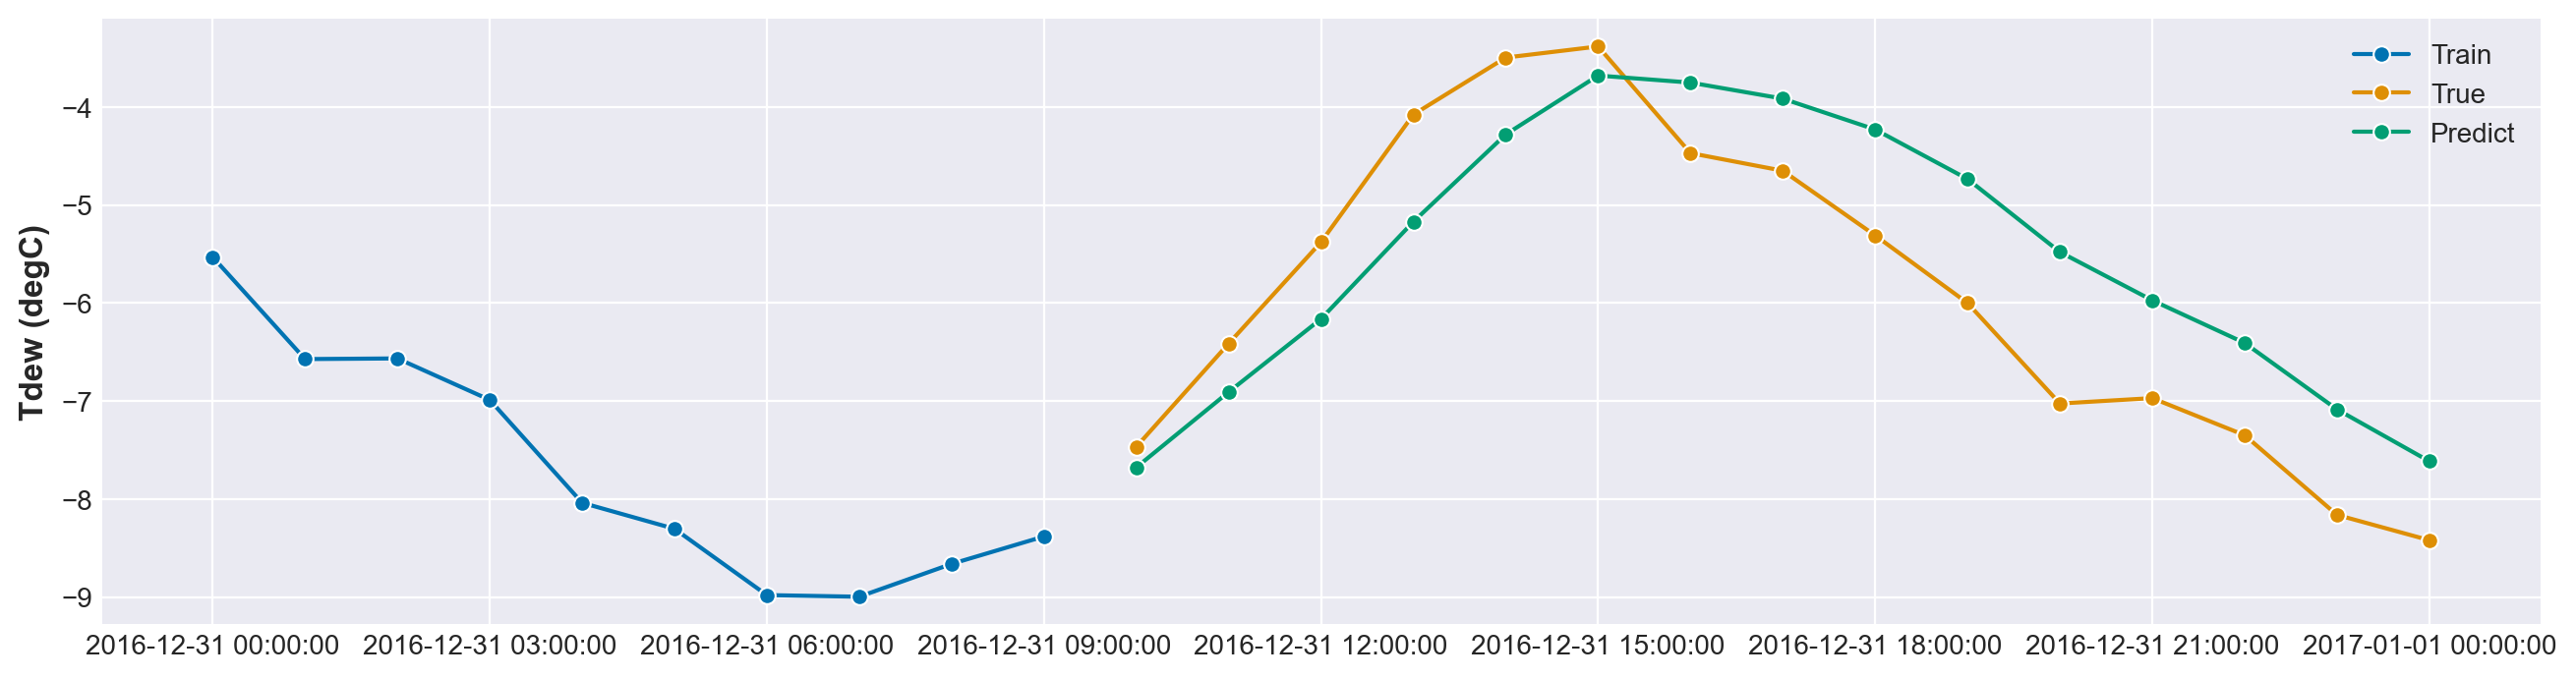

In [50]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [51]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

(32, 5)


,mean_test_MeanAbsoluteError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsoluteError
0,1.460874,5.625398,4.598037,{'forecaster__deseasonalizer__model': 'additiv...,11.0
1,1.544910,5.344878,4.486132,{'forecaster__deseasonalizer__model': 'additiv...,23.0
2,1.549721,5.271998,3.752765,{'forecaster__deseasonalizer__model': 'additiv...,27.0
3,1.028025,3.437629,4.155810,{'forecaster__deseasonalizer__model': 'additiv...,4.0
4,1.461656,5.388050,4.133834,{'forecaster__deseasonalizer__model': 'additiv...,12.0


### Backtesting Insample Prediction

In [52]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)

losses = [
    MeanSquaredError(),
    MeanSquaredError(square_root=True),
    MeanAbsoluteError(),
    MeanAbsolutePercentageError(),
    MeanAbsolutePercentageError(symmetric=False),
    MeanAbsoluteScaledError(),
]

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    scoring=losses,
    return_data=True,
)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,test_MeanAbsoluteScaledError
0,0.559009,7.388161,0.327983,70039,2016-12-28 06:00:00,2009-01-01 00:00:00 -9.120000 2009-01-01 01...,Date Time 2016-12-28 07:00:00 2.108333 2016...,2016-12-28 07:00:00 2.197835 2016-12-28 08:...,0.477368,0.191223,1.059185
1,0.381330,7.284887,0.427170,70054,2016-12-28 21:00:00,2009-01-01 00:00:00 -9.120000 2009-01-01 01...,Date Time 2016-12-28 22:00:00 2.130000 2016...,2016-12-28 22:00:00 2.322292 2016-12-28 23:...,0.304918,0.157183,0.676650
2,1.247460,7.139813,0.338319,70069,2016-12-29 12:00:00,2009-01-01 00:00:00 -9.120000 2009-01-01 01...,Date Time 2016-12-29 13:00:00 2.190000 2016...,2016-12-29 13:00:00 2.528478 2016-12-29 14:...,1.170186,1.060973,2.597193
3,1.141777,7.399731,0.333090,70084,2016-12-30 03:00:00,2009-01-01 00:00:00 -9.120000 2009-01-01 01...,Date Time 2016-12-30 04:00:00 -3.541667 2016...,2016-12-30 04:00:00 -3.430955 2016-12-30 05:...,0.949724,4.592310,2.107947
4,0.856630,7.237161,0.354320,70099,2016-12-30 18:00:00,2009-01-01 00:00:00 -9.120000 2009-01-01 01...,Date Time 2016-12-30 19:00:00 -3.065000 2016...,2016-12-30 19:00:00 -2.508040 2016-12-30 20:...,0.774744,0.144157,1.719185


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Tdew (degC)'>)

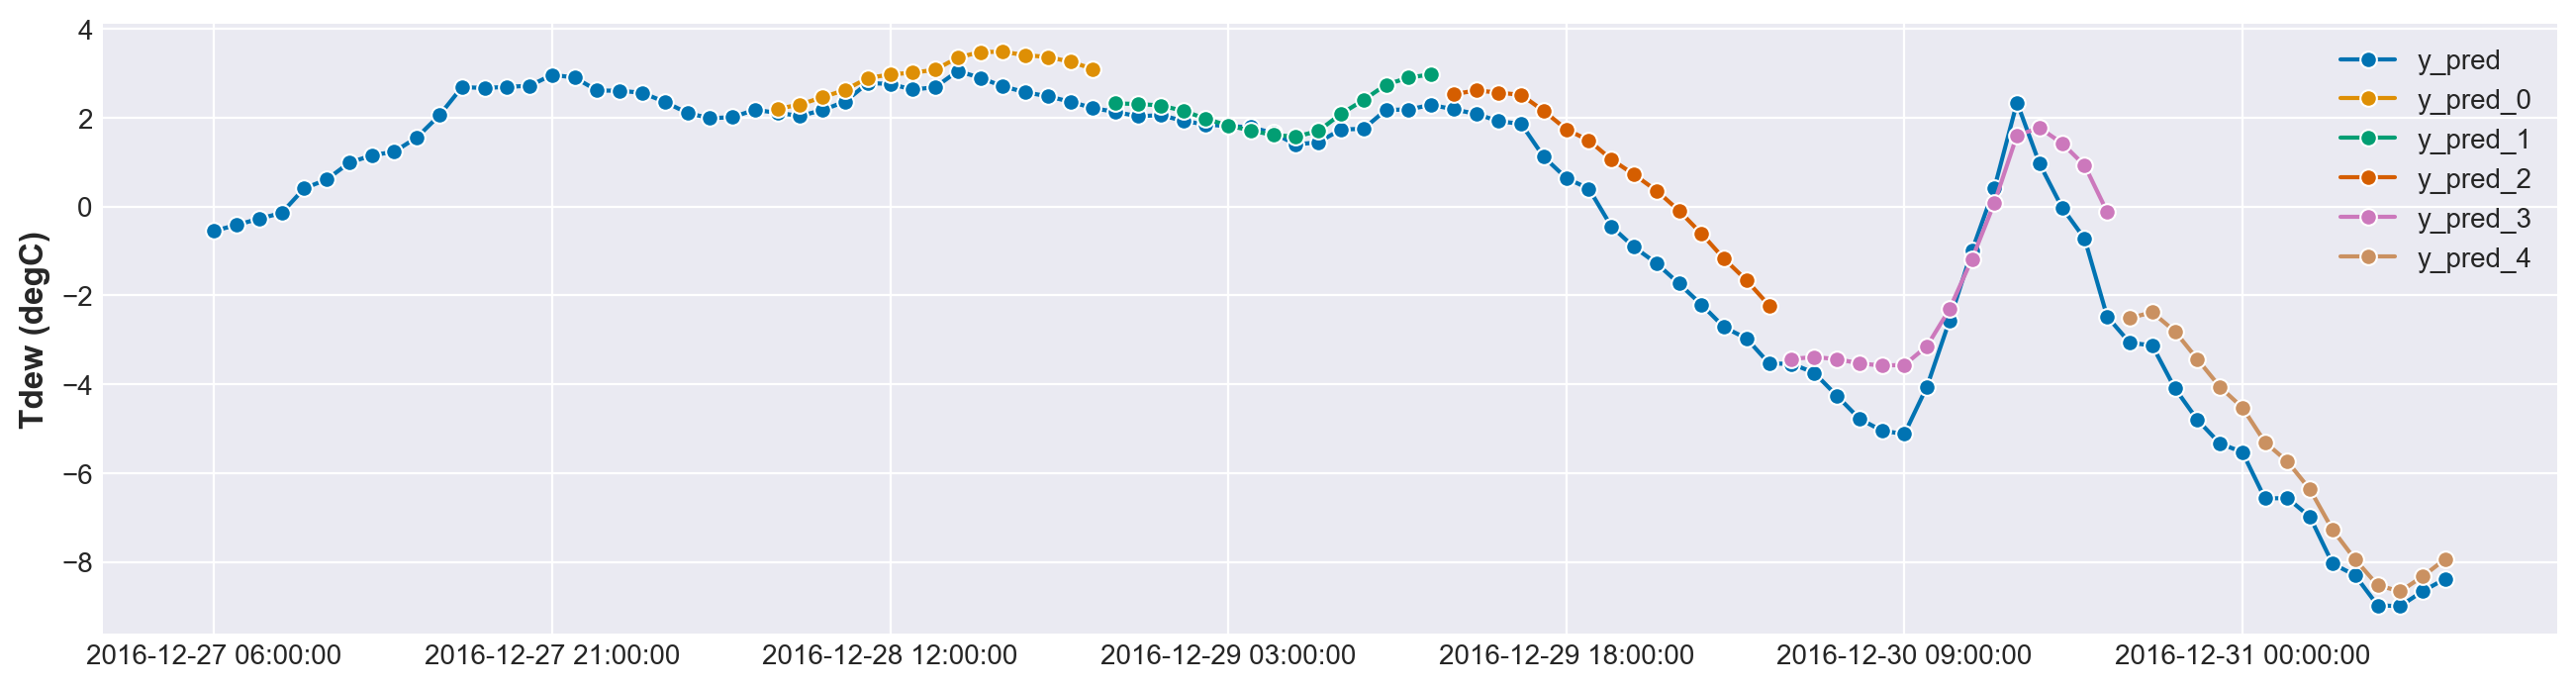

In [53]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

### Get best model Parameters

In [26]:
gscv.best_forecaster_.get_fitted_params()

{'forecaster': TransformedTargetForecaster(steps=[('imputer_y',
                                     Imputer(method='ffill', random_state=80)),
                                    ('deseasonalizer',
                                     ConditionalDeseasonalizer(sp=24)),
                                    ('detrender',
                                     Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
                                    ('reducer',
                                     RecursiveTabularRegressionForecaster(estimator=Ridge(alpha=0.01, random_state=80),
                                                                          pooling='global',
                                                                          window_length=24))]),
 'steps': [('x_transforner',
   TransformerPipeline(steps=[('imputer_x',
                               Imputer(method='ffill', random_state=80))])),
  ('forecaster',
   TransformedTargetForecaster(steps=[('imputer_y',
       

### Train Model Parameter

In [34]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__coef"
]
model_intercept = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_coeff {model_coeff}", end="\n\n")
print(f"model_intercept {model_intercept}", end="\n\n")

model_n_features_in 28

model_fname_in ['Tdew (degC)_lag_1' 'Tdew (degC)_lag_2' 'Tdew (degC)_lag_3'
 'Tdew (degC)_lag_4' 'Tdew (degC)_lag_5' 'Tdew (degC)_lag_6'
 'Tdew (degC)_lag_7' 'Tdew (degC)_lag_8' 'Tdew (degC)_lag_9'
 'Tdew (degC)_lag_10' 'Tdew (degC)_lag_11' 'Tdew (degC)_lag_12'
 'Tdew (degC)_lag_13' 'Tdew (degC)_lag_14' 'Tdew (degC)_lag_15'
 'Tdew (degC)_lag_16' 'Tdew (degC)_lag_17' 'Tdew (degC)_lag_18'
 'Tdew (degC)_lag_19' 'Tdew (degC)_lag_20' 'Tdew (degC)_lag_21'
 'Tdew (degC)_lag_22' 'Tdew (degC)_lag_23' 'Tdew (degC)_lag_24' 'p (mbar)'
 'T (degC)' 'Tpot (K)' 'rh (%)']

model_coeff [ 5.16146981e-01 -3.29301609e-02 -6.47241972e-03 -8.97937710e-03
 -1.36456721e-03 -1.91484491e-03 -7.54635295e-04 -1.32916418e-03
 -3.28160567e-03 -6.42335659e-03  3.55703143e-03 -1.13226073e-03
  2.89605511e-03  2.24197470e-04 -6.11471528e-04  7.92887006e-04
 -1.15377393e-03  2.94919543e-03 -1.89483327e-04 -2.37499735e-04
  8.59985396e-04  3.52657863e-03  4.92348702e-03 -5.62801177e-03
 -9.0520538

### model cutoff

In [35]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

DatetimeIndex(['2016-12-31 09:00:00'], dtype='datetime64[ns]', name='Date Time', freq='H') 2016-12-31 09:00:00


### Model Cloning

In [36]:
from sklearn.base import clone

model = clone(gscv.best_forecaster_).set_params(**gscv.best_params_)

dir(model)

['_X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rpow__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_anytag_notnone_set',
 '_anytag_notnone_val',
 '_anytagis',
 '_anytagis_then_set',
 '_check_X',
 '_check_X_y',
 '_check_estimators',
 '_check_fh',
 '_check_names',
 '_check_steps',
 '_clone_flags',
 '_coerce_estimator_tuple',
 '_components',
 '_config',
 '_config_dynamic',
 '_converter_store_y',
 '_cutoff',
 '_dunder_concat',
 '_fh',
 '_fit',
 '_get_class_flag',
 '_get_class_flags',
 '_get_estimator_list',
 '_get_estimator_names',
 '_get_estimator_tuples',
 '_get_fitted_params',
 '_get_fitted_params_defa

### Model saving 

In [37]:
# gscv.best_forecaster_.save("../results/elastic_net")

import joblib

joblib.dump(gscv.best_forecaster_, "../results/ridge.pkl")

['../results/ridge.pkl']

### Features importance

<Axes: >

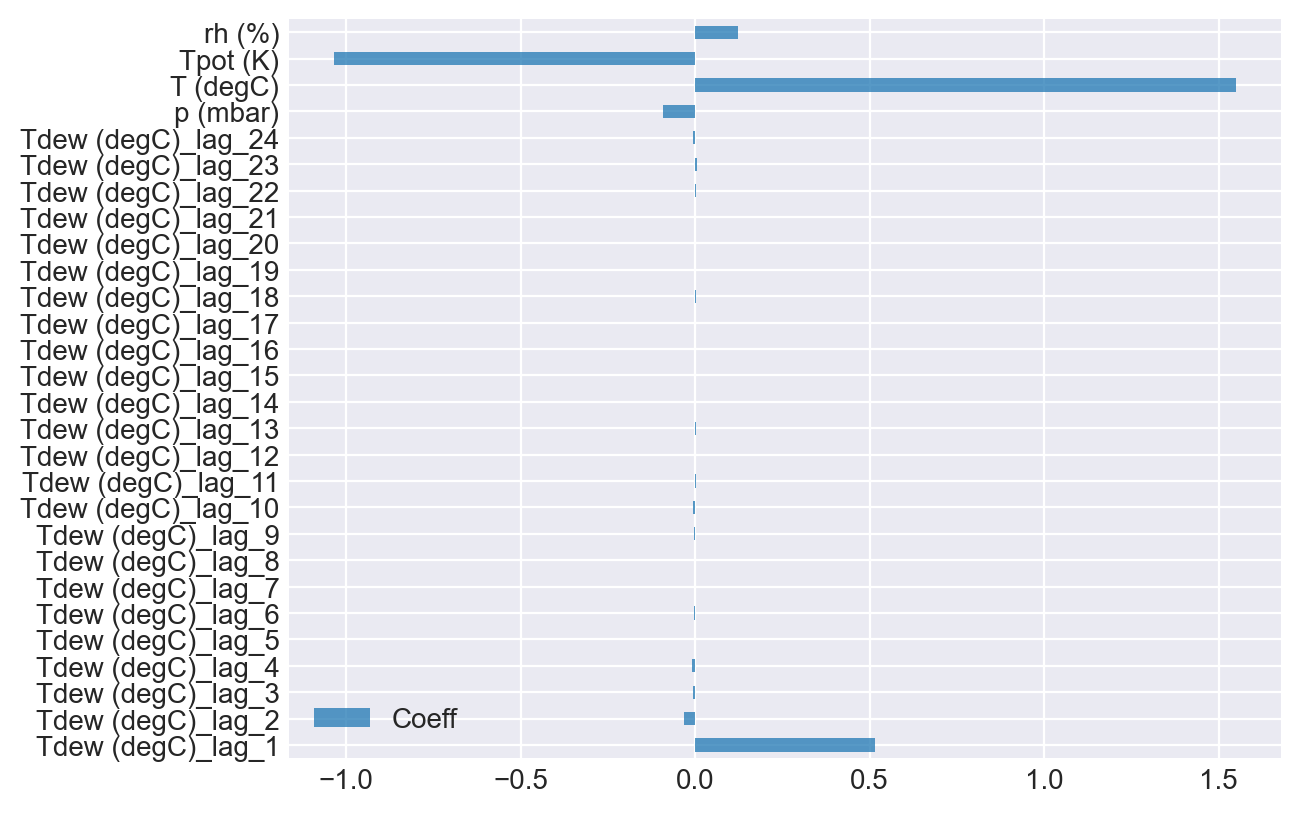

In [38]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)